# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic_signs_data/train.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train.shape[1:]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

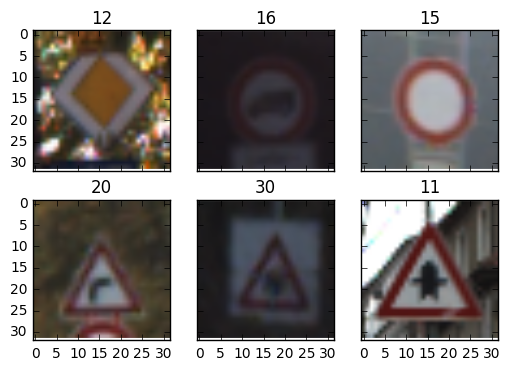

In [4]:
import random
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')

# Randomly select 6 different categories
categories = random.sample(range(n_classes), 6)

# Randomly select 1 image each from the 6 categories and display
image_1 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[0]])
ax1.imshow(X_train[image_1,:,:,:])
ax1.set_title(categories[0])
image_2 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[1]])
ax2.imshow(X_train[image_2,:,:,:])
ax2.set_title(categories[1])
image_3 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[2]])
ax3.imshow(X_train[image_3,:,:,:])
ax3.set_title(categories[2])
image_4 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[3]])
ax4.imshow(X_train[image_4,:,:,:])
ax4.set_title(categories[3])
image_5 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[4]])
ax5.imshow(X_train[image_5,:,:,:])
ax5.set_title(categories[4])
image_6 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[5]])
ax6.imshow(X_train[image_6,:,:,:])
ax6.set_title(categories[5])

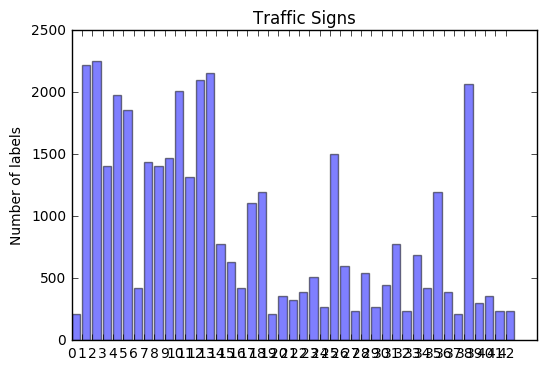

In [5]:
import numpy as np
import collections

# Display the distribution of the categories
counts = collections.Counter(y_train)
signs = set(y_train)
y_pos = np.arange(len(signs))
counts = [counts[i] for i in range(len(signs))]

plt.bar(y_pos, counts, alpha=0.5)
plt.xticks(y_pos, signs)
plt.ylabel('Number of labels')
plt.title('Traffic Signs')
plt.show()

From this, we see that the data is quite skewed. We will create additional data to balance the distribution by transforming (rotate, shear, translate) the images.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
import numpy as np
import cv2

# Source: https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb
def transform_image(img, ang_range, shear_range, trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), ang_rot, 1)
    
    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    
    # Shear
    pts1 = np.float32([[5,5], [20,5], [5,20]])
    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform() - shear_range/2
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    shear_M = cv2.getAffineTransform(pts1, pts2)
    
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    return img

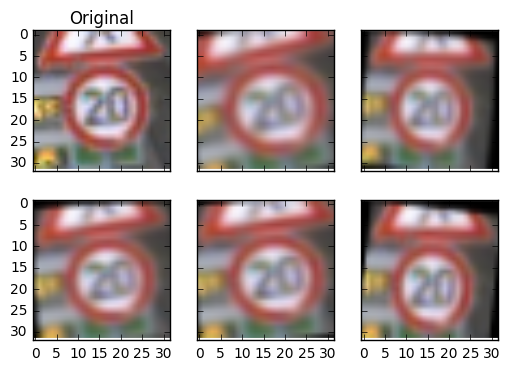

In [7]:
# Display transformed images
test_image = X_train[6, :, :]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
ax1.imshow(test_image)
ax1.set_title('Original')
ax2.imshow(transform_image(test_image, 10, 5, 2))
ax3.imshow(transform_image(test_image, 10, 5, 2))
ax4.imshow(transform_image(test_image, 10, 5, 2))
ax5.imshow(transform_image(test_image, 10, 5, 2))
ax6.imshow(transform_image(test_image, 10, 5, 2))

In [8]:
# Generate additional data
def generate_data(X_train, y_train, ang_range=20, shear_range=10, trans_range=5, num_data=None):
    X_train_res = list(X_train)
    y_train_res = list(y_train)
    num_y = len(set(y_train))
    counts = collections.Counter(y_train)
    # If num_data is not set, generate additional data for other categories
    # to match the number of images with the category with most number of images
    if num_data is None:
        max_count = max(counts.values())
    else:
        max_count = num_data
    y_train_index = np.arange(len(y_train))
    # Loop through the 43 categories
    for i in range(num_y):
        # Number of images to generate
        num_images = max_count - counts[i]
        index_to_rand = y_train_index[y_train==i]
        # Randomly choose images to transform
        rand_indexes = [random.choice(index_to_rand) for _ in range(num_images)]
        for j in rand_indexes:
            X_train_res.append(transform_image(X_train[j], ang_range, shear_range, trans_range))
            y_train_res.append(i)
    return X_train_res, y_train_res

In [9]:
# Histogram equzliation
def equalize_image(X_train):
    result = []
    image_shape = X_train.shape[1:]
    # For each images
    for i in range(len(X_train)):
        image = X_train[i].reshape((image_shape[0]*image_shape[1], image_shape[2]))
        image = cv2.equalizeHist(image)
        result.append(image.reshape(image_shape))
    return np.array(result)

In [10]:
from sklearn.utils import shuffle

# Apply histogram equalization on each image
X_train = equalize_image(X_train)
X_test = equalize_image(X_test)

# Normalize data so that every image has range -0.5 to 0.5
X_train = X_train / 255 - 0.5
X_test = X_test / 255 - 0.5

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

In [11]:
from sklearn.model_selection import train_test_split
# Split data to have training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [12]:
import tensorflow as tf

In [18]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    
    # Layer 1: Convolutional.
    # Input = 32x32x3. Ouput = 28x28x6.
    conv1_W = tf.get_variable("conv1_W", shape=(5, 5, 3, 6), initializer=tf.contrib.layers.xavier_initializer())
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling.
    # Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional.
    # Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.get_variable("conv2_W", shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer())
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling.
    # Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten.
    # Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected.
    # Input = 400. Output = 120.
    fc1_W = tf.get_variable("fc1_W", shape=(400, 120), initializer=tf.contrib.layers.xavier_initializer())
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected.
    # Input = 120. Output = 84.
    fc2_W  = tf.get_variable("fc2_W", shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer())
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected.
    # Input = 84. Output = 43.
    fc3_W  = tf.get_variable("fc3_W", shape=(84, 43), initializer=tf.contrib.layers.xavier_initializer())
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 50
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #num_examples = len(X_train)
    
    print("Training...")
    print()
    ang_range = 10
    shear_range = 5
    trans_range = 1
    for i in range(EPOCHS):
        #X_train, y_train = shuffle(X_train, y_train)
        X_train_new, y_train_new = generate_data(X_train, y_train, ang_range, shear_range, trans_range)
        X_train_new, y_train_new = np.array(X_train_new), np.array(y_train_new)
        X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        ang_range *= 0.9
        shear_range *= 0.9
        trans_range *= 0.9
        for offset in range(0, len(X_train_new), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.903

EPOCH 2 ...
Validation Accuracy = 0.944

EPOCH 3 ...
Validation Accuracy = 0.966

EPOCH 4 ...
Validation Accuracy = 0.969

EPOCH 5 ...
Validation Accuracy = 0.977

EPOCH 6 ...
Validation Accuracy = 0.976

EPOCH 7 ...
Validation Accuracy = 0.985

EPOCH 8 ...
Validation Accuracy = 0.983

EPOCH 9 ...
Validation Accuracy = 0.984

EPOCH 10 ...
Validation Accuracy = 0.986

EPOCH 11 ...
Validation Accuracy = 0.985

EPOCH 12 ...
Validation Accuracy = 0.981

EPOCH 13 ...
Validation Accuracy = 0.990

EPOCH 14 ...
Validation Accuracy = 0.981

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.987

EPOCH 17 ...
Validation Accuracy = 0.986

EPOCH 18 ...
Validation Accuracy = 0.986

EPOCH 19 ...
Validation Accuracy = 0.984

EPOCH 20 ...
Validation Accuracy = 0.987

EPOCH 21 ...
Validation Accuracy = 0.986

EPOCH 22 ...
Validation Accuracy = 0.988

EPOCH 23 ...
Validation Accuracy = 0.989

EPOCH 24 ...
Validation Accura

In [19]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


# VGG16 Net

In [12]:
from tensorflow.contrib.layers import flatten

def VGG_16(x):    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x64.
    conv1_W = tf.get_variable("conv1_W", shape=(3, 3, 3, 64), initializer=tf.contrib.layers.xavier_initializer())
    conv1_b = tf.Variable(tf.zeros(64))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 32x32x64. Output = 16x16x64.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    # conv1 = tf.nn.dropout(conv1, p)

    # SOLUTION: Layer 2: Convolutional. Input = 16x16x64. Output = 16x16x128.
    conv2_W = tf.get_variable("conv2_W", shape=(3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer())
    conv2_b = tf.Variable(tf.zeros(128))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 16x16x128. Output = 8x8x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 8x8x128. Output = 8192.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 8192. Output = 4096.
    fc1_W = tf.get_variable("fc1_W", shape=(8192, 4096), initializer=tf.contrib.layers.xavier_initializer())
    fc1_b = tf.Variable(tf.zeros(4096))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 4096. Output = 4096.
    fc2_W = tf.get_variable("fc2_W", shape=(4096, 4096), initializer=tf.contrib.layers.xavier_initializer())
    fc2_b  = tf.Variable(tf.zeros(4096))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 4096. Output = 43.
    fc3_W = tf.get_variable("fc3_W", shape=(4096, 43), initializer=tf.contrib.layers.xavier_initializer())
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
import tensorflow as tf

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = VGG_16(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 20
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    ang_range = 10
    shear_range = 5
    trans_range = 1
    for i in range(EPOCHS):
        #X_train, y_train = shuffle(X_train, y_train)
        X_train_new, y_train_new = generate_data(X_train, y_train, ang_range, shear_range, trans_range)
        X_train_new, y_train_new = np.array(X_train_new), np.array(y_train_new)
        X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        ang_range *= 0.9
        shear_range *= 0.9
        trans_range *= 0.9
        for offset in range(0, len(X_train_new), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'vggnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.958

EPOCH 2 ...
Validation Accuracy = 0.977

EPOCH 3 ...
Validation Accuracy = 0.979

EPOCH 4 ...
Validation Accuracy = 0.982

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.992

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.988

EPOCH 11 ...
Validation Accuracy = 0.993

EPOCH 12 ...
Validation Accuracy = 0.986

EPOCH 13 ...
Validation Accuracy = 0.987

EPOCH 14 ...
Validation Accuracy = 0.990

EPOCH 15 ...
Validation Accuracy = 0.987

EPOCH 16 ...
Validation Accuracy = 0.987

EPOCH 17 ...
Validation Accuracy = 0.987

EPOCH 18 ...
Validation Accuracy = 0.986

EPOCH 19 ...
Validation Accuracy = 0.992

EPOCH 20 ...
Validation Accuracy = 0.987

Model saved


In [16]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('vggnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.908


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocessed the data by using histogram equalization and then recale all images intensity to values between -0.5 to 0.5. Histogram equalization will take away the effect of brightness variation.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I split the given training data into training and validation set (77.77% for training and 33.33% for validation). Addition data are generated so that the distribution of the categories is the same. Data are being generated by randomly selecting images from training set and randomly rotating, shearing, and translating it. This will make the parameter of bias for all categories to be about the same.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architecture is the LeNet architecture. There is no dropout as it led to poorer performance (0.5 probability of keeping).

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used adam for optimizer (0.9 for exponential decay rate for the 1st moment estimates, 0.999 for exponential decay rate for the 2nd moment estimates), 128 as batch size and 50 epochs. The learning rate for the adam optimizer is 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I used the LeNet architecture on the original data as a benchmark and try different data preprocessing to improve the accuracy. I also tried VGGNet on the preprocessed data and got poorer performance (1% lower test accuracy) as compared to LeNet. The given problem has only 43 categories and it might explain why LeNet (shallower) performs better than VGGNet. One thing that i could have tried is to apply dropout on the VGGNet to reduce overfitting.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [22]:
import glob
from scipy.misc import imresize

In [23]:
image_list = []
for img in glob.glob("test_image/image_*.jpg"):
    image_list.append(imresize(plt.imread(img), (32, 32)))
image_list = np.asarray(image_list)

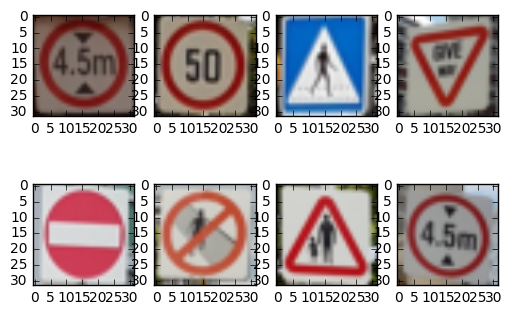

In [24]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)

ax1.imshow(image_list[0])
ax2.imshow(image_list[1])
ax3.imshow(image_list[2])
ax4.imshow(image_list[3])
ax5.imshow(image_list[4])
ax6.imshow(image_list[5])
ax7.imshow(image_list[6])
ax8.imshow(image_list[7])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

For all the traffic signs above, only the 2nd and 5th images matches the available categories in the given dataset.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [27]:
import copy
image_list_ori = copy.copy(image_list)
# Apply histogram equalization on each image
image_list = equalize_image(image_list)

# Normalize data so that every image has range -0.5 to 0.5
image_list = image_list / 255 - 0.5

In [28]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    logits_res = sess.run(logits, feed_dict={x: image_list})

In [73]:
logits_exp = np.exp(logits_res)
rows = np.sum(logits_exp, axis=1)
probs = logits_exp / rows[:, None]

In [76]:
np.argmax(probs, axis=1)

array([36,  2, 24, 13, 17,  5, 27,  9])

Display images from training dataset that correspond with the predicted label for own test data.

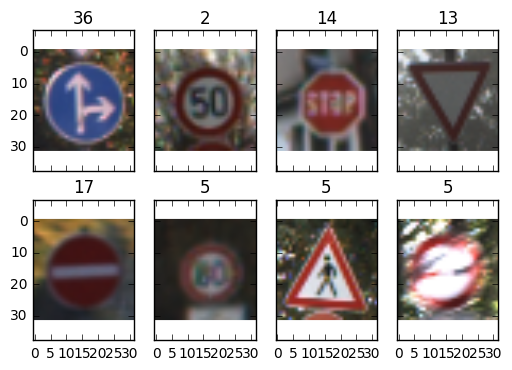

In [81]:
X_train2, y_train2 = train['features'], train['labels']

import random
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, sharex='col', sharey='row')

# Categories that are predicted for taken pictures.
categories = [36, 2, 14, 13, 17, 5, 27, 9]

# Randomly select 1 image each from the 8 categories and display
image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[0]])
ax1.imshow(X_train2[image_1,:,:,:])
ax1.set_title(categories[0])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[1]])
ax2.imshow(X_train2[image_2,:,:,:])
ax2.set_title(categories[1])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[2]])
ax3.imshow(X_train2[image_3,:,:,:])
ax3.set_title(categories[2])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[3]])
ax4.imshow(X_train2[image_4,:,:,:])
ax4.set_title(categories[3])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[4]])
ax5.imshow(X_train2[image_5,:,:,:])
ax5.set_title(categories[4])
image_6 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[5]])
ax6.imshow(X_train2[image_6,:,:,:])
ax6.set_title(categories[5])
image_7 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[6]])
ax7.imshow(X_train2[image_7,:,:,:])
ax7.set_title(categories[5])
image_8 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[7]])
ax8.imshow(X_train2[image_8,:,:,:])
ax8.set_title(categories[5])

Out of the 8 images, only 2 images (2nd and 5th) got predicted correctly. But only 2 out of 8 images matches the category given in training dataset. So the model has predicted correctly for all the test images that are valid. For the 5th and 7th images, although there are no categories that matches the image, the model managed to find a category that matches the image quite well.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [90]:
with tf.Session() as sess:
    top_5 = sess.run(tf.nn.top_k(tf.constant(logits_res), k=5))

In [91]:
top_5

TopKV2(values=array([[  1.44287786e+01,  -5.09058952e-01,  -5.25310934e-01,
         -1.49321723e+00,  -1.72984552e+00],
       [  3.09790492e+00,   1.61924875e+00,   7.33701944e-01,
          3.34929943e-01,   1.55996516e-01],
       [  1.04219427e+01,   7.26470423e+00,   3.71449447e+00,
          2.18509650e+00,   1.38183606e+00],
       [  5.15547447e+01,  -2.62028351e-03,  -2.58216119e+00,
         -5.10155725e+00,  -5.35912132e+00],
       [  9.07318687e+00,   1.47968102e+00,   1.21849895e+00,
          9.12595332e-01,  -4.90255892e-01],
       [  1.05258155e+00,   3.48759294e-01,  -1.74437985e-01,
         -4.11538750e-01,  -6.48772299e-01],
       [  8.83612156e+00,   5.21326017e+00,  -3.76325041e-01,
         -1.17219067e+00,  -1.59504235e+00],
       [  9.40370560e+00,  -3.39944333e-01,  -3.80525470e-01,
         -5.58829308e-01,  -2.41938567e+00]], dtype=float32), indices=array([[36, 40, 19, 38,  3],
       [ 2,  7,  5,  8,  3],
       [24, 18, 31, 27, 26],
       [13,  2,  5

In [94]:
top_5[1][0]

array([36, 40, 19, 38,  3], dtype=int32)

In [ ]:
image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[0]])
ax1.imshow(X_train2[image_1,:,:,:])

Display original image and the 5 images with categories that are predicted for the image.

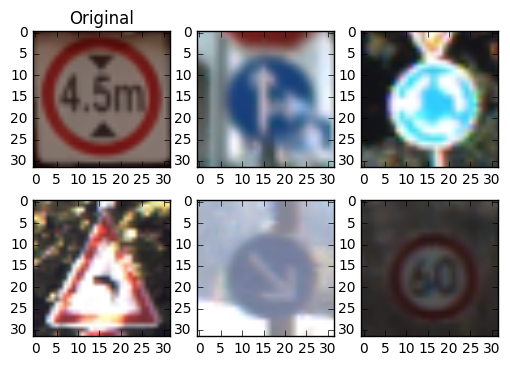

In [100]:
image_index = 0
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

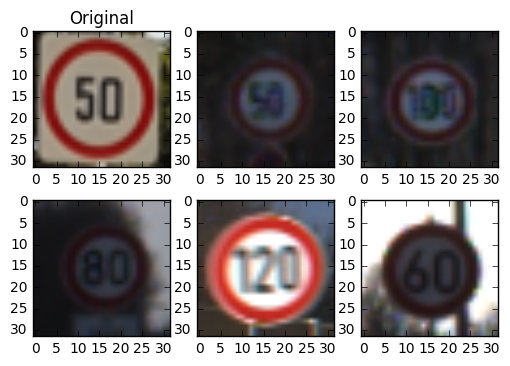

In [101]:
image_index = 1
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

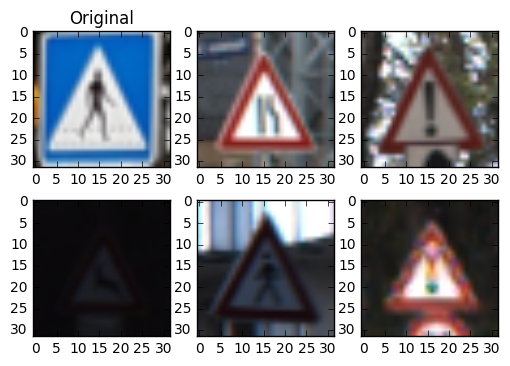

In [102]:
image_index = 2
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

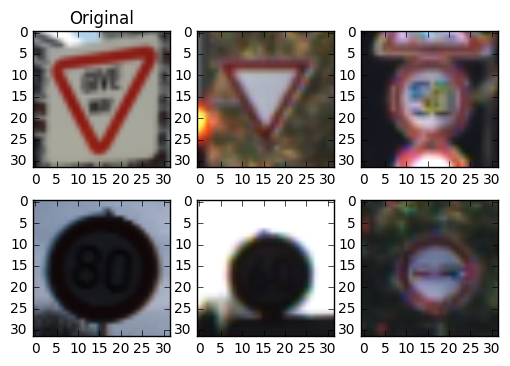

In [103]:
image_index = 3
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

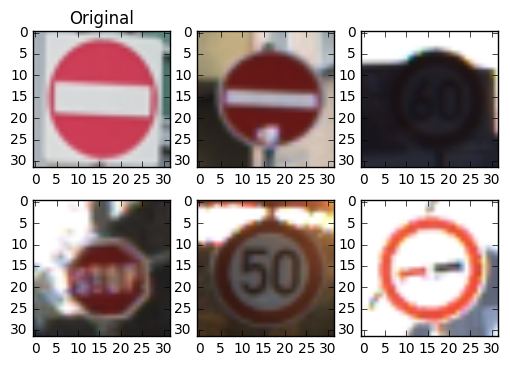

In [104]:
image_index = 4
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

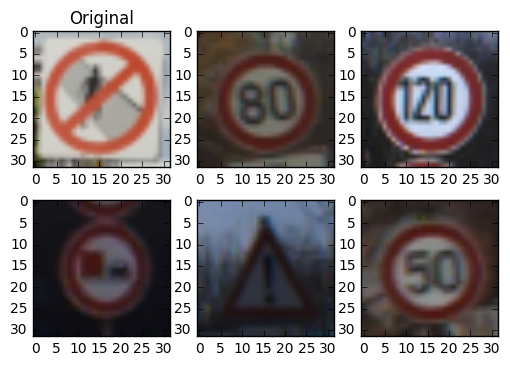

In [105]:
image_index = 5
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

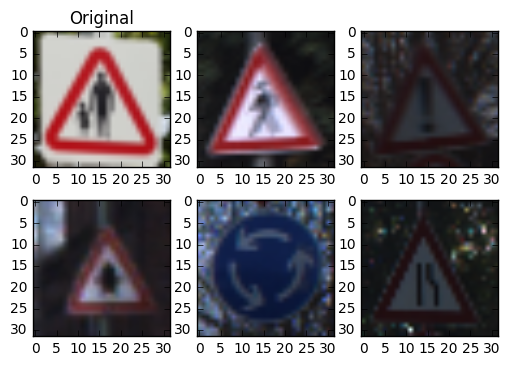

In [106]:
image_index = 6
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

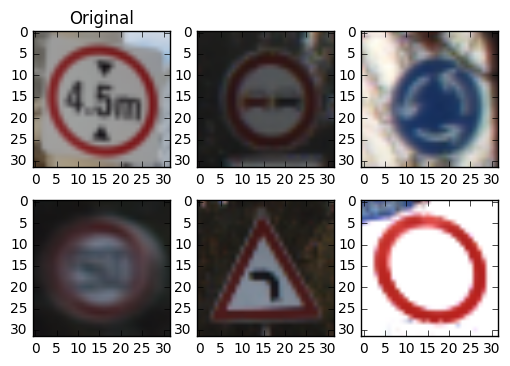

In [107]:
image_index = 7
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

**Answer:**

The test images (2nd and 5th) that has its category in the training dataset are all being predicted correctly.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.